
A model which fit with the bank needs: 

The bank wants to know if a client is likely or not to be able to reimburse the loan. If the client is doing a payment default it is considered as a positive event. For the TARGET default = 1. 

- **TP (True Positives)** : it is the case where the prediction is positive et the true values is positive too. The client make a default payment and the model predict a default payment. pred_y = 1 and true_y = 1

- **TN (True Negatives)** : it is when the client does reimburse the loan, and the client actually truely reimbourse the loan. pred_y = 0 and true_y = 0

- **FP (False Positive)** : it is when the client actually could reimburse the loan but the model predict a default payement. pred_y = 1 and true_y = 0 

- **FN (False Negative)** : when the client make a default payement but the model predict that he will not.  pred_y = 0 and true_y = 1

A bank does not want to give a loan if the client can't reimburse (FN is the worst case). It also does not want to miss a opportunity to make money by giving a loan which will be reimburse, it is however less negative than the FN case (FP is the second worst case). So the model need to have the maximise TP and TN and minimise FP and FN but more specificly FN. 

Binary classifier are scored usually with those metrics: 

**Confusion Matrix**

The confusion matrix is one of the best ways to evaluate the performance of a classifier. The basic idea is to count the number of times instances from one class are correctly classified or incorrectly classified as another class.

The rows in a confusion matrix represent the actual class, while each column represents the predicted class. A perfect classifier would only have true positives and true negatives, meaning its confusion matrix would only have non-zero values on its diagonal.

In a confusion matrix, there are two types of errors that you need to be aware of: false positives or Type I errors and false negatives or Type II errors. These terms come from hypothesis testing in statistics and are used interchangeably with classification problems.

From a confusion matrix you can calculate all kinds of different metrics including the most simple one accuracy. **Accuracy is defined as the sum of your correctly classified instances divided by the total amount of instances.** However, accuracy has a severe bias when we have unbalanced target (AS IT IS FOR THIS PROJECT). Indeed, if we have 90% of negative a dummy classifier will have an accuracy of 90% which at first sight seems to be good, but is obviously not. That's why accuracy is generally not the preferred performance metric, especially when you’re dealing with an imbalanced dataset.

**Precision and Recall**

The confusion matrix hands you valuable information, but sometimes you may need a more concise metric. One way is to calculate the accuracy of all the instances classified in the positive class. This is called the precision. Since precision only looks at Type I errors, it is often used alongside another metric called recall (also known as sensitivity or the true positive rate). Precision = TP / (TP + FP) and recall = TP / (TP + FN)

It is often helpful to combine precision and recall into one metric called the F1 score. The F1 score is defined as the harmonic mean of precision and recall. It gives a heavier weight to lower values meaning it will always fall inside precision and recall and favors when these values are close. F1 = TP / (TP + ((FN + FP) / 2))

***One way to give a heavier weight to precision or recall is by using the Fβ score which gives β times more importance to recall. Hence values less than 1 will favor precision and values greater than 1 will favor recall.***

**Precision/Recall Trade-off**

Sometimes you care more about precision and other times you will care mostly about recall. For example, if you trained a classifier to detect fraudulent credit card activity, it wouldn’t be that big of a deal if your classifier has a low precision as long as it has a really high recall (meaning there might be a few false alarms, but almost all fraudulent activity will be detected).

On the other hand, let’s say you train a classifier that detects if a mushroom in nature is edible (not poisonous). You would probably prefer a classifier that you can trust when it predicts a mushroom is edible (high precision) but misclassifies some edible mushrooms as poisonous (low recall), rather than a classifier that misclassifies poisonous mushrooms as edible.

As you might be able to tell by now, increasing precision reduces recall, and vice versa. This is called the precision/recall trade-off.

To understand the precision/recall tradeoff you must understand how classifiers assign instances to the positive or negative class. Every classifier has a decision function that computes a score/probability and if that score/probability is greater than a certain threshold, the instance is assigned to the positive class; otherwise it is assigned to the negative class.

By changing this threshold you can effectively alter the amount of false positives at the expense of your false negatives. Increasing the threshold will increase precision and reduce recall. While decreasing the threshold increases recall and reduces precision.

**The precision/recall curve** allows you to see exactly what recall you will get given a desired precision. In the above example you would probably want to pick a precision around 90% before the sharp drop off. You can do this by searching for the lowest possible threshold that gives you at least your desired precision.

By now you can probably tell it is fairly easy to achieve any precision you want on your classifier by setting a high enough threshold. But, a classifier that has a high precision and a really low recall is not very useful. **Knowing the business problem will help you decide on a good precision/recall tradeoff.**


**Receiver Operating Characteristic (ROC) Curve**

The receiver operating characteristic curve is another tool that is used to analyze the errors of binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate (recall) against the false positive rate (Fall-Out).

By measuring the area under the curve (AUC) we can score the performance of our classifiers. A perfect classifier will have an area of 1, whereas a random classifier will have an area of 0.5.

Now you might be wondering whether you should use the precision/recall curve or the ROC curve since they are very similar. It is best practice to use the precision/recall curve when your dataset is imbalanced or when you care about the false positives more than the false negatives. Otherwise, use the ROC curve.


For our study, without any bank preofessional around, we still can guess that FN is worst than FP. 
We then obviously want to maximise the ROC AUC but concerning precision and recall, for our particular problem we want to maximise the recall. Or a least minimise FN and FP to maximise profite. 

**Definition of a loss function adapted to our case**

To better evaluate the models, we will build a cost function taking into account gains and losses (coefficients) multipled by the number of clients for each case of the confusion matrix. The following gains and losses will be taken into account:

- FN mean losses --
- TN mean gains +
- TP mean no losses/no gains
- FP mean losses of potential gains - 

Having a discussion with someone from the company could give use the average gain of TN and average losses of FN and FP. As we can't we will use as exemple that a average FN losses is 200,000 dollars, an average gains for a credit is 20,000 dollars which also mean that a FP is a average losses of 20,000 potential gains.

With those value we can have a total revenues of tot_rev = 20,000 * TN - 200,000 * FN 

We can normalise this metric to have the percentage of the maximum possible revenue which is the total of negative (FP + TN) * 20,000

max revenue rate is (20,000 * TN - 200,000 * FN) / (FP + TN) * 20,000

Then we have a news loss function to maximise.





# Step of the modelisation

To find the best model we will proceed as followed : 

First we need to preprocess the datatset. Then find the best algorithm and finally find the best hyperparameters for the model. 

For the preprocessing we need to evaluate several criteria : 
- do we remove/keep or impute the NaN
- do we encoded features (StandardScaler  for numerical  and OH encoder for categorical)
- As the target is unbalanced, do we use sampling technic like SMOTE or unbalanced paramater in some algorithm
- Is feature selection usefull (meaning: gain of training time vs no loss in perfromance)

I will evaluated with the function (below) evaluation all of those condition with several algortihm : 
- DummyClassifier to have metrics baseline
- Logistic regression 
- RandomForest classifier
- LightGBM classifier (this algorithm seems to be the faster for this study, more over it is the only one which accept NA)

When the best combinaison preprocessing/algorithm is found, we will tune the hyperparameters using two methods: Bayesian Optimisation, and Random Search CV. The metrics to optimise hyperparameter will be the ROC AUC. and we also will tune the hyperparameters with the specific metrics define above. 

Results from model evaluation a available below in a Markdown cells + in the visualisation file. 


At the end there is the model interpretability evaluation using features importance, LIME and SHAP.

In [2]:
'''
This cells is the final model optimisation combine in one function. All the evaluation steps are below
'''

import numpy as np
import pandas as pd
import gc
import time
import re 
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split,  StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn import metrics
from contextlib import contextmanager

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


def preprocessing(df):
    # Read data
    
    df = df.replace([np.inf, -np.inf], np.nan)

    df_train, df_test = train_test_split(df,
                                          test_size=.2,
                                          random_state=5)

    print('Train dataset shape: ', df_train.shape)
    print('Test dataset shape: ', df_test.shape)

    # Definition of target and features variables

    X_train = df_train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
    y_train = df_train['TARGET']

    X_test = df_test.drop(['TARGET', 'SK_ID_CURR'], axis=1)
    y_test = df_test['TARGET']

    print('X train shape before preprocessing: ', X_train.shape)
    print("Target distribution: {}".format(Counter(y_train)))

    # Categorical features with One-Hot encode
    categorical_features = X_train.select_dtypes(exclude=np.number).columns
    steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]
    categorical_transformer = Pipeline(steps=steps)

    # Numeric features with StandardScaler
    numeric_features = X_train.select_dtypes(include=np.number).columns
    steps = [('scaler', StandardScaler())]
    numeric_transformer = Pipeline(steps=steps)

    # Categorical features with OneHot Encoder
    preprocessor = ColumnTransformer(
              transformers=[('num', numeric_transformer, numeric_features),
                            ('cat', categorical_transformer, categorical_features)
                            ])

    # Feature selection
    steps = [('preprocessing', preprocessor),
             ('sfm', SelectFromModel(LGBMClassifier(n_jobs=-1)))]
    pipeline = Pipeline(steps=steps)   
    pipeline.fit(X_train, y_train)

    X_train = pipeline.transform(X_train)
    X_test = pipeline.transform(X_test)
    
    print('X train shape after preprocessing and features selection: ', X_train.shape)

    # Export preprocessing in pkl
    with open('pipeline', 'wb') as file:
        pickle.dump(pipeline, file)
    
    # Save feature names to future features importance eval
    onehot_columns = list(preprocessor.named_transformers_['cat'].named_steps['encoder'].\
                          get_feature_names_out(input_features=categorical_features))
    numeric_features_list = list(numeric_features)
    feats = np.concatenate((numeric_features_list, onehot_columns))
    feats = feats[pipeline.named_steps['sfm'].get_support()]

    # Rename columns to avoid JSON character
    charac = ','
    charac_2 = ':'
    new_list = []
    for item in feats: 
            if (charac in item) | (charac_2 in item):
                    item = re.sub(charac, '_', item)
                    item = re.sub(charac_2, '_', item)
                    new_list.append(item)
            else:
                    new_list.append(item)
    feats = new_list

    df_train = pd.DataFrame(X_train, columns=feats)
    df_train['TARGET'] = np.array(y_train)

    df_test = pd.DataFrame(X_test, columns=feats)
    df_test['TARGET'] = np.array(y_test)

    return df_train, df_test


def kfold_lightgbm(train_df, test_df, num_folds, debug=False):

    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

    #train_df = train_df.replace([np.inf, -np.inf], np.nan)
    #test_df = test_df.replace([np.inf, -np.inf], np.nan)

    # Cross validation model
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=123)

    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    y_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET']]
    
    fold_idx = folds.split(train_df[feats], train_df['TARGET'])
    for n_fold, (train_idx, valid_idx) in enumerate(fold_idx):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization

        clf = LGBMClassifier(
            n_estimators=1000,
            learning_rate=0.02,
            colsample_bytree=0.2352167642701535,
            max_depth=9,
            min_child_weight=34.67802513470199,
            min_split_gain=0.772886577362599,
            num_leaves=44,
            reg_alpha=0.6466454272437308,
            reg_lambda=0.883716377059081,
            subsample=0.1498951237319723,
            scale_pos_weight=11.387150050352467,
            silent=-1,
            verbose=-1,
            )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose=200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        y_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    
    # Export model in pkl and plot feature importance
    print(len(clf.feature_importances_))
    with open('classifier', 'wb') as file:
        pickle.dump(clf, file)

    display_importances(feature_importance_df)
    evaluation(test_df, y_preds)
    
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('visualisation/lgbm_importances.png')

def evaluation(df_test, y_prob):

    y_test = df_test['TARGET']

    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
    precision_, recall_, thresh_ = precision_recall_curve(y_test, y_prob)

    # calculate the g-mean for each threshold
    g_means = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(g_means)

    y_prob = (y_prob >= thresholds[ix]).astype(bool)

    tn, fp, fn, tp = confusion_matrix(y_test, y_prob).ravel()
    print(f'TN = {tn}, FP = {fp}, FN = {fn}, TP = {tp}')
    conf_mat = [[tp,fn],[fp,tn]]

    auc = metrics.roc_auc_score(y_test, y_prob)
    recall = metrics.recall_score(y_test, y_prob)
    precision = metrics.precision_score(y_test, y_prob)
    f1 = metrics.f1_score(y_test, y_prob)

    ######################################
    print(f'Testset: \
    threshold = {thresholds[ix]:.0%}, \
    G-Mean = {g_means[ix]:.0%}, \
    AUC = {auc:.0%}, \
    recall = {recall:.0%}, \
    precision = {precision:.0%}, \
    f1 = {f1:.0%}')
    ######################################

    # Evaluation plot
    plt.figure(figsize=(10, 10))

    # ROC curve
    plt.subplot(221)
    plt.axis('scaled')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title("ROC Curve")
    plt.plot(fpr, tpr, label='LightGBM', color='blue')
    plt.plot([0, 1], [0, 1], '--', lw=2, color='orange', label='no skill')
    plt.scatter(fpr[ix], tpr[ix], marker='o', s=100, color='r', label='Best')
    plt.text(0.95, 0.05, f'AUC = {auc:.3f}', ha='right',
            fontsize=12, weight='bold')
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")

    # G-Means vs Threshold curve
    plt.subplot(222)
    plt.plot(thresholds, g_means, 'r')
    plt.scatter(thresholds[ix], g_means[ix], marker='o', s=100, color='r', label='Best')
    plt.xlim(0,1)
    plt.xlabel('Proba threshold')
    plt.ylim(0,1)
    plt.ylabel('G-Means')
    plt.title('G-Means vs. threshold')

    # Precision recall curve 
    plt.subplot(223)
    plt.plot(recall_, precision_, 'teal')
    plt.scatter(recall, precision, marker='o', s=100, color='r', label='Best')
    plt.xlim(0,1)
    plt.xlabel('Recall')
    plt.ylim(0,1)
    plt.ylabel('Precision')
    plt.title('Precision-recall curve')

    # Confusion matrix
    plt.subplot(224)
    sns.heatmap(conf_mat, annot=True, fmt='.0f', cbar=False, cmap='viridis')
    plt.xticks([0.5,1.5], [1,0])
    plt.yticks([0.5,1.5], [1,0])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion matrix')

    plt.tight_layout(pad=1.1)
    plt.show()

def main(debug = False):
    num_rows = 10000 if debug else None

    df = pd.read_csv('data/model_dataset.csv',
                nrows=num_rows,
                low_memory=False,
                verbose=False,
                encoding='ISO-8859-1',
                dtype={'Special': 'object'}
                )
    with timer("Preprocessing"):
        df_train, df_test = preprocessing(df)
        del df
        gc.collect()
    with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(df_train, df_test, num_folds=5, debug=debug)

if __name__ == "__main__":
    with timer("Full model run"):
        main()

Train dataset shape:  (246008, 433)
Test dataset shape:  (61503, 433)
X train shape before preprocessing:  (246008, 431)
Target distribution: Counter({0: 226047, 1: 19961})


# Environment setup & graphical parameters

In [5]:
import numpy as np
import pandas as pd
import gc
import time
import re 
import pickle
from collections import Counter
import seaborn as sns
import warnings

from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from contextlib import contextmanager
import matplotlib.pyplot as plt

warnings.simplefilter(action='ignore')


In [6]:
# Read data
df = pd.read_csv('data/model_dataset.csv',
                low_memory=False,
                verbose=False,
                encoding='ISO-8859-1',
                dtype={'Special': 'object'}
                )
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR
0,100002,1,Cash loans,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,Cash loans,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,Revolving loans,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,Cash loans,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,Cash loans,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Cleaning - Encoding - TrainTest 

I will use lightGBM classifier as algotrithm as it is faster compare to XGBoost and RandomForest. 

In [12]:
# Preprocessing

def preprocessing(df, NaN_remove=False, impute=False, sampling=False, feat_select=False):
       t0 = time.time()

       df = df.replace([np.inf, -np.inf], np.nan)
       
       # Missing value -> Imputation
       if NaN_remove:
              df = df.dropna(axis = 0)
              df.shape

       df_train, df_test = train_test_split(df,
                                          test_size=.2,
                                          random_state=5)

       print('Train dataset shape: ', df_train.shape)
       print('Test dataset shape: ', df_test.shape)

       # Definition of target and features variables

       X_train = df_train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
       y_train = df_train['TARGET']

       X_test = df_test.drop(['TARGET', 'SK_ID_CURR'], axis=1)
       y_test = df_test['TARGET']

       print('X train shape before preprocessing: ', X_train.shape)
       print("Target distribution: {}".format(Counter(y_train)))

       # Encoding

       if impute:
              print('Impute =', impute)
              numeric_features = X_train.select_dtypes(include=np.number).columns
              steps = [('med_imputer', SimpleImputer(strategy='median')),
                     ('scaler', StandardScaler())
                     ]
              numeric_transformer = Pipeline(steps=steps)

              categorical_features = X_train.select_dtypes(exclude=np.number).columns
              steps=[('mode_imputer', SimpleImputer(strategy='most_frequent')),
                     ('encoder', OneHotEncoder(handle_unknown='ignore'))]
              categorical_transformer = Pipeline(steps=steps)

              preprocessor = ColumnTransformer(
              transformers=[('num', numeric_transformer, numeric_features),
                            ('cat', categorical_transformer, categorical_features)
                            ])

              preprocessor.fit(X_train)

              X_train = preprocessor.transform(X_train)
              X_test = preprocessor.transform(X_test)

              print('X train shape: ', X_train.shape)

              if sampling:
                     print('Sampling =', impute)
                     # Sampling because of unbalance TARGET
                     over = SMOTE(sampling_strategy=0.1)
                     under = RandomUnderSampler(sampling_strategy=0.5)

                     steps = [('over', over),
                              ('under', under)
                            ]
                     sm = Pipeline(steps=steps)

                     X_train, y_train = sm.fit_resample(X_train, y_train)
                     X_test, y_test = sm.resample(X_test, y_test)
                     print('X_train shape: ', X_train.shape)
                     print("Target distribution of {}: {}".format('y', Counter(y_train)))

       else:
              print('Impute =', impute)
              numeric_features = X_train.select_dtypes(include=np.number).columns
              steps = [('scaler', StandardScaler())]
              numeric_transformer = Pipeline(steps=steps)

              categorical_features = X_train.select_dtypes(exclude=np.number).columns
              steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))]
              categorical_transformer = Pipeline(steps=steps)

              preprocessor = ColumnTransformer(
              transformers=[('num', numeric_transformer, numeric_features),
                            ('cat', categorical_transformer, categorical_features)
                            ])
              
              preprocessor.fit(X_train)

              X_train = preprocessor.transform(X_train)
              X_test = preprocessor.transform(X_test)
              
              print('X train shape: ', X_train.shape)

       # Train, Test split
       onehot_columns = list(preprocessor.named_transformers_['cat'].named_steps['encoder'].\
                            get_feature_names_out(input_features=categorical_features))
       numeric_features_list = list(numeric_features)
       feats = np.concatenate((numeric_features_list, onehot_columns))

       if feat_select: 
              print('Features selection')
              from sklearn.feature_selection import SelectFromModel

              sfm = SelectFromModel(LGBMClassifier(n_jobs=-1)).fit(X_train, y_train)
              X_train = sfm.transform(X_train)
              X_test = sfm.transform(X_test)

              print('X train shape after features selection: ', X_train.shape)

              feats = feats[sfm.get_support()]

       # Rename columns to avoid JSON character
       charac = ','
       charac_2 = ':'
       new_list = []
       for item in feats: 
              if (charac in item) | (charac_2 in item):
                     item = re.sub(charac, '_', item)
                     item = re.sub(charac_2, '_', item)
                     new_list.append(item)
              else:
                     new_list.append(item)
       feats = new_list

       print("Preprocessing done in {:.0f}s".format(time.time() - t0))

       return X_train, y_train, X_test, y_test, feats

# Preprocessing evaluation

In [8]:
from sklearn.metrics import confusion_matrix, roc_auc_score, make_scorer
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

import warnings

In [9]:
# Making our cost function
def score_loans(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    score = (20000 * tn - 200000 * fn) / ((fp + tn) * 20000)
    return score

score_function = make_scorer(score_loans)

Train dataset shape:  (246008, 433)
Test dataset shape:  (61503, 433)
X train shape before preprocessing:  (246008, 431)
Target distribution: Counter({0: 226047, 1: 19961})
Impute = False
X train shape:  (246008, 541)
Features selection
X_train shape after features selection:  (246008, 140)
Preprocessing done in 65s
Model evaluation


/Users/franck/opt/anaconda3/envs/datascience_devenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/franck/opt/anaconda3/envs/datascience_devenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/franck/opt/anaconda3/envs/datascience_devenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/

DummyClassifier evaluation done in 3s
LGBMClassifier evaluation done in 115s


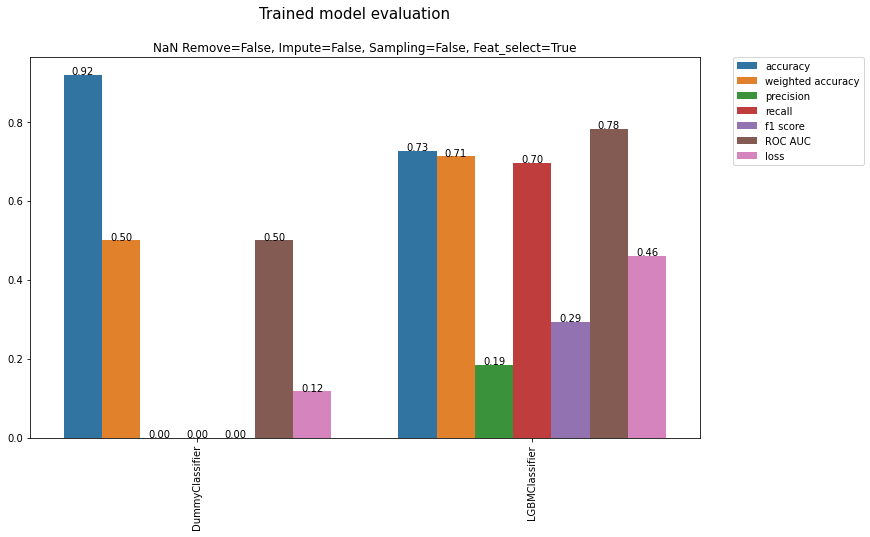

In [11]:
# Evaluation
warnings.filterwarnings('ignore')
t0 = time.time()
dfs = [] 
models = [
          ('DummyClassifier', DummyClassifier()),
          ('LGBMClassifier',LGBMClassifier(n_jobs=-1,
                                           scale_pos_weight=Counter(df['TARGET'])[0]/Counter(df['TARGET'])[1])),
          #('LogisticRegression', LogisticRegression(n_jobs=-1)),
          #('RandomForestClassifier', RandomForestClassifier(n_jobs=-1)),
        ]
results = []
names = []
scoring = {'accuracy': 'accuracy',
           'balanced_accuracy': 'balanced_accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1_score': 'f1',
           'roc_auc': 'roc_auc',
           'loss' : score_function      
           }

# evaluate model
NaN_remove=False
impute=False
sampling=False
feat_select=True

X_train, y_train, X_test, y_test, feats = preprocessing(df,
                                                        NaN_remove=NaN_remove,
                                                        impute=impute,
                                                        sampling=sampling,
                                                        feat_select=feat_select)

print('Model evaluation')
for name, model in models:
    t0 = time.time()
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
    results.append(scores)
    names.append(name)
    df_res = pd.DataFrame(scores)
    df_res['model'] = name
    df_res['imputed'] = impute
    df_res['sampling'] = sampling
    model.fit(X_train, y_train)
    dfs.append(df_res)
    ypred = model.predict(X_test)
    print("{} evaluation done in {:.0f}s".format(name, time.time() - t0))
final = pd.concat(dfs, ignore_index=True)

# Structure model score dataframe
eval=final[['model',
            'test_accuracy',
            'test_balanced_accuracy',
            'test_precision',
            'test_recall',
            'test_f1_score',
            'test_roc_auc', 'test_loss']]
eval_ag=eval.groupby("model").mean()
eval_ag['model']=eval_ag.index
eval_ag.rename(columns={'test_roc_auc': 'ROC AUC',
                        'test_accuracy':'accuracy',
                        'test_balanced_accuracy':'weighted accuracy',
                        'test_precision':'precision',
                        'test_recall':'recall',
                        'test_f1_score':'f1 score',
                        'test_loss':'loss'},inplace=True)
stack=eval_ag.melt(id_vars=['model'])

# Plot model score
fig, axes= plt.subplots(figsize=(12,7))
plt.suptitle('Trained model evaluation', fontsize=15)
plt.title('NaN Remove={}, Impute={}, Sampling={}, Feat_select={}'.format(NaN_remove, impute, sampling, feat_select))
ax=sns.barplot(x='model', y='value', hue='variable', data=stack, ax=axes)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 0.001,
            "%.2f" % p.get_height(),
            ha="center") 
    
for tick in ax.get_xticklabels():
        tick.set_rotation(90)  
plt.xlabel("")
plt.ylabel("")
plt.legend(bbox_to_anchor=(1.05,1),loc=2,  borderaxespad=0.)
plt.draw()
plt.savefig('visualisation/Preprocess_eval_NaN-{}_Impute-{}_Sampling-{}_Fselect-{}.png'.format(NaN_remove, impute, sampling, feat_select),
            facecolor='w',
            edgecolor='w',
            bbox_inches='tight')


In [ ]:
# RFE CV feature selection

from sklearn.feature_selection import RFECV

estimator = LGBMClassifier()

min_features_to_select = 100  # Minimum number of features to consider
rfecv = RFECV(
    estimator=estimator,
    step=10,
    cv=StratifiedKFold(3),
    scoring=make_scorer(roc_auc_score),
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
    )
plt.show()

Learning Curve done in 20s


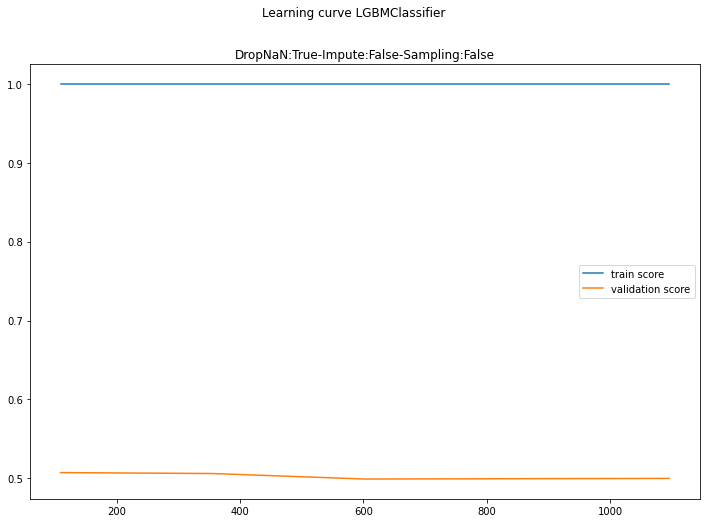

In [17]:
# Learning curve to evaluate over or underfitting
t0 = time.time()

models = [
          ('LGBMClassifier',LGBMClassifier()),
          #('LogisticRegression', LogisticRegression()),
          #('RandomForestClassifier', RandomForestClassifier()),
        ]

for name, model in models:
  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
  N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=cv, scoring=make_scorer(roc_auc_score),
                                              train_sizes=np.linspace(0.1, 1, 5))


  plt.figure(figsize=(12, 8))
  plt.plot(N, train_score.mean(axis=1), label='train score')
  plt.plot(N, val_score.mean(axis=1), label='validation score')
  plt.suptitle(f'Learning curve {name}')
  plt.title(f'DropNaN:{NaN_remove}-Impute:{impute}-Sampling:{sampling}')
  plt.legend()
  plt.savefig('LearningCurve_NaN-{}_Impute-{}_Sampling-{}.png'.format(NaN_remove, impute, sampling),
            facecolor='w',
            edgecolor='w',
            bbox_inches='tight')
  print("visualisation/Learning Curve done in {:.0f}s".format(time.time() - t0))

## Preprocessing/algorithm selection conclusion

Evalation on preprocessing on tree algorithm : DummyClassifier, lightGBM, Logistic regression and Random Forrest to predict credit score. Default parameter are use for the classifier. 

For first trials, I use all the feature without any feature engineering

1. **Remove NaN + Encoding (cat:OH, num:StandScaler)**
    - X shape before preprocessing:  (1713, 431)
    - Target distribution of y: Counter({0: 1567, 1: 146})
    - Impute = False
    - X shape after preprocessing:  (1713, 526)
    - (1370, 527)
    - (343, 527)
    - Preprocessing done in 9s
    
    The best models were LBGMclassifier and Logistic regression with ROC-AUC = 0.68 and 0.56 respectively. The time to process is a few secondes. The learning curve on LGBMclassifier shows a overfitting of the model

2. **Keep NaN + Encoding (cat:OH, num:StandScaler)** (Only LightGBM can handle NaN)
    - X shape before preprocessing:  (307511, 431)
    - Target distribution of y: Counter({0: 282686, 1: 24825})
    - Impute = True
    - X shape:  (307511, 541)
    - (246008, 542)
    - (61503, 542)
    - Preprocessing done in 12s
    
    LBGMclassifier ROC-AUC = 0.78. The time to process was 247 secondes. The learning curve on LGBMclassifier shows a overfitting of the model


3. **Imputation NaN(cat:Mode, num:Median) + Encoding (cat:OH, num:StandScaler)**
    - X shape before preprocessing:  (307511, 431)
    - Target distribution of y: Counter({0: 282686, 1: 24825})
    - Impute = False
    - X shape:  (307511, 539)
    - (246008, 540)
    - (61503, 540)
    - Preprocessing done in 53s

    The best models were LBGMclassifier and Logistic regression with ROC-AUC = 0.78 and 0.77, respectively. The time to process was 166s.


4. **Imputation NaN(cat:Mode, num:Median) + Encoding (cat:OH, num:StandScaler) + sampling SMOTE**
    - X shape before preprocessing:  (307511, 431)
    - Target distribution: Counter({0: 282686, 1: 24825})
    - Impute = True
    - X shape:  (307511, 539)
    - Sampling = True
    - X shape:  (84804, 539)
    - Target distribution of y: Counter({0: 56536, 1: 28268})
    - (67843, 540)
    - (16961, 540)
    - Preprocessing done in 82s

    The best models were LBGMclassifier and RandomForest with ROC-AUC = 0.81 and 0.78, respectively. The time to process is less than a minute. The learning curve shows no overfitting.

The sampling does not seems to be very effective, more over lightGBM classifier can handle unbalanced target. We will use this the preprocessing wihtout sampling to test features selection. 

5. **Keep NaN + Encoding (cat:OH, num:StandScaler) + Feature selection** (LightGBM only)
    - X shape before preprocessing:  (307511, 431)
    - Target distribution: Counter({0: 282686, 1: 24825})
    - Impute = False
    - X shape after preprocessing:  (307511, 541)
    - Features selection
    - X shape after features selection:  (307511, 143)
    - (246008, 144)
    - (61503, 144)
    - Preprocessing done in 73s
    
    LBGMclassifier ROC-AUC = 0.78. The time to process is a one minutes.

6. **Imputation NaN(cat:Mode, num:Median) + Encoding (cat:OH, num:StandScaler) + Feature selection** 
    - X shape before preprocessing:  (307511, 431)
    - Target distribution: Counter({0: 282686, 1: 24825})
    - Impute = False
    - X shape after preprocessing:  (307511, 539)
    - Features selection
    - X shape after features selection:  (307511, 130)
    - (246008, 131)
    - (61503, 131)
    - Preprocessing done in 101s
    
    LBGMclassifier ROC-AUC = 0.78. The time to process is a one minutes. 

7. **Imputation NaN(cat:Mode, num:Median) + Encoding (cat:OH, num:StandScaler) + Sampling SMOTE + Feature selection**
    - X shape before preprocessing:  (307511, 431)
    - Target distribution: Counter({0: 282686, 1: 24825})
    - Impute = True
    - X shape:  (307511, 539)
    - Sampling = True
    - X shape:  (84804, 539)
    - Target distribution of y: Counter({0: 56536, 1: 28268})
    - Features selection
    - X shape after features selection:  (84804, 133)
    - (67843, 134)
    - (16961, 134)
    - Preprocessing done in 88s
    
    LBGMclassifier ROC-AUC = 0.80. The time to process is 30 secondes. 

8. **Imputation NaN(cat:Mode, num:Median) + Encoding (cat:OH, num:StandScaler) + Feature selection** for lightGBM with hyperparater 'unbalanced' = True
    - X shape before preprocessing:  (307511, 431)
    - Target distribution: Counter({0: 282686, 1: 24825})
    - Impute = False
    - X shape after preprocessing:  (307511, 541)
    - Features selection
    - X shape after features selection:  (307511, 143)
    - (246008, 144)
    - (61503, 144)
    - Preprocessing done in 68s
    
    LBGMclassifier ROC-AUC = 0.78. The time to process is 100 secondes. 

9. **Imputation NaN(cat:Mode, num:Median) + Encoding (cat:OH, num:StandScaler) + Feature selection** for lightGBM with hyperparater 'scale_pos_weight'= Counter(df['TARGET'])[0]/Counter(df['TARGET'])[1] ~ 10
    - X shape before preprocessing:  (307511, 431)
    - Target distribution: Counter({0: 282686, 1: 24825})
    - Impute = False
    - X shape after preprocessing:  (307511, 541)
    - Features selection
    - X shape after features selection:  (307511, 143)
    - (246008, 144)
    - (61503, 144)
    - Preprocessing done in 68s
    
    LBGMclassifier ROC-AUC = 0.78. The time to process is 88 secondes. 

For the hyperparameter tuning I will use to preprocessing 6. because of ROC-AUC and Fbeta score whiche are high and the less preprocessing step. More over removing some features allows a faster modelisation without a lost in classification precision.


# Hyperparameters Tuning

In [59]:
# Bayesian Optimisation of lightGBM classifier Hyperparameter

import lightgbm
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold

NaN_remove=False
impute=False
sampling=False
feat_select=True
weight = Counter(df['TARGET'])[0]/Counter(df['TARGET'])[1]

X_train, y_train, X_test, y_test, feats = preprocessing(df,
                                                        NaN_remove=NaN_remove,
                                                        impute=impute,
                                                        sampling=sampling,
                                                        feat_select=feat_select)

def lgbm_eval(num_leaves,
              colsample_bytree,
              subsample,
              max_depth,
              reg_alpha,
              reg_lambda,
              min_split_gain,
              min_child_weight,
              ):

    lgbm_train = lightgbm.Dataset(X_train, y_train, params={'verbose': -1})
    fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=666)
    cv_fold = fold.split(X_train, y_train)

    params = {'application':'binary',
              'n_estimators':1000,
              'learning_rate':0.02,
              'scale_pos_weight':weight,
              'nthread':-1,
              'verbose':-1
              } 

    params["num_leaves"] = int(num_leaves)
    params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
    params['subsample'] = max(min(subsample, 1), 0)
    params['max_depth'] = int(max_depth)
    params['reg_alpha'] = max(reg_alpha, 0)
    params['reg_lambda'] = max(reg_lambda, 0)
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight

    clf = lightgbm.cv(params=params,
                      train_set=lgbm_train,
                      metrics=['auc'], 
                      folds=cv_fold, 
                      num_boost_round=100,
                      early_stopping_rounds=100,
                      verbose_eval=-1
                    )

    return clf['auc-mean'][-1]

clf_bo = BayesianOptimization(lgbm_eval, {'num_leaves': (30, 45),
                                          'colsample_bytree': (0.1, 1),
                                          'subsample': (0.1, 1),
                                          'max_depth': (5, 15),
                                          'reg_alpha': (0, 1),
                                          'reg_lambda': (0, 1),
                                          'min_split_gain': (0, 1),
                                          'min_child_weight': (30, 45)
                                        })

clf_bo.maximize(init_points=4, n_iter=20)



X shape before preprocessing:  (307511, 431)
Target distribution: Counter({0: 282686, 1: 24825})
Impute = False
X shape after preprocessing:  (307511, 541)
Features selection
X shape after features selection:  (307511, 143)
(246008, 144)
(61503, 144)
Preprocessing done in 64s
|   iter    |  target   | colsam... | max_depth | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7873   |  0.852    |  9.513    |  34.2     |  0.1608   |  36.47    |  0.45     |  0.08428  |  0.6955   |
|  2        |  0.7874   |  0.1564   |  13.21    |  34.42    |  0.5256   |  39.84    |  0.4602   |  0.1847   |  0.2351   |
|  3        |  0.7879   |  0.2561   |  5.173    |  42.81    |  0.9898   |  31.39    |  0.0853   |  0.7511   |  0.5982   |
|  4        |  0.7873   |  0.6988   |  13.59    |  33.84    |  0.1364   |  36.66    |  0.4282   |  0.03223  |  0.

In [60]:
params_gbm = clf_bo.max['params']
params_gbm['max_depth'] = round(params_gbm['max_depth'])
params_gbm['num_leaves'] = round(params_gbm['num_leaves'])
params_gbm

{'colsample_bytree': 0.2352167642701535,
 'max_depth': 9,
 'min_child_weight': 34.67802513470199,
 'min_split_gain': 0.772886577362599,
 'num_leaves': 44,
 'reg_alpha': 0.6466454272437308,
 'reg_lambda': 0.883716377059081,
 'subsample': 0.1498951237319723}

In [105]:
# Research of best Hyperparamter with RandomSearch CV

from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

n = 10
weight = Counter(df['TARGET'])[0]/Counter(df['TARGET'])[1]

lgbm = LGBMClassifier(n_estimators=1000,
                      silent=-1,
                      verbose=-1,
                      metric='None',
                      n_jobs=-1,
                      application='binary',
                      learning_rate=0.02,
                      scale_pos_weight=weight,
                      )


lgbm_param = {'num_leaves': np.linspace(30, 45, 7, dtype='int'),
              'min_split_gain': stats.uniform(loc=0.1, scale=0.8),
              'min_child_weight': np.linspace(30, 45, 10),
              'subsample': stats.uniform(loc=0.1, scale=0.8),
              'colsample_bytree': stats.uniform(loc=0.1, scale=0.2),
              'max_depth': np.linspace(5, 15, 10, dtype='int'),
              'reg_alpha': np.linspace(0, 1, 10),
              'reg_lambda': np.linspace(0, 1, 10)}

grid = RandomizedSearchCV(lgbm,
                          lgbm_param,
                          n_iter=n,
                          cv=5,
                          scoring='roc_auc',
                          n_jobs=-1,
                          verbose=True,
                          random_state=13)

grid.fit(X_train, y_train)

print(round(grid.best_score_, 3))
print(grid.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.789
{'colsample_bytree': 0.2588042700910767, 'max_depth': 10, 'min_child_weight': 45.0, 'min_split_gain': 0.629529728284177, 'num_leaves': 35, 'reg_alpha': 0.0, 'reg_lambda': 0.3333333333333333, 'subsample': 0.7856487540697591}


# Model evaluation

In [25]:
# Fit the model with best params
NaN_remove=False
impute=False
sampling=False
feat_select=True
weight = Counter(df['TARGET'])[0]/Counter(df['TARGET'])[1]

X_train, y_train, X_test, y_test, feats = preprocessing(df,
                                                        NaN_remove=NaN_remove,
                                                        impute=impute,
                                                        sampling=sampling,
                                                        feat_select=feat_select)

model = LGBMClassifier(
            application='binary',
            n_estimators=1000,
            learning_rate=0.02,
            colsample_bytree=0.2352167642701535,
            max_depth=9,
            min_child_weight=34.67802513470199,
            min_split_gain=0.772886577362599,
            num_leaves=44,
            reg_alpha=0.6466454272437308,
            reg_lambda=0.883716377059081,
            subsample=0.1498951237319723,
            scale_pos_weight=weight,
            silent=-1,
            verbose=-1,
            )
model.fit(X_train, y_train)

X shape before preprocessing:  (307511, 431)
Target distribution: Counter({0: 282686, 1: 24825})
Impute = False
X shape after preprocessing:  (307511, 541)
Features selection
X shape after features selection:  (307511, 143)
(246008, 144)
(61503, 144)
Preprocessing done in 63s


LGBMClassifier(application='binary', colsample_bytree=0.2352167642701535,
               learning_rate=0.02, max_depth=9,
               min_child_weight=34.67802513470199,
               min_split_gain=0.772886577362599, n_estimators=1000,
               num_leaves=44, reg_alpha=0.6466454272437308,
               reg_lambda=0.883716377059081,
               scale_pos_weight=11.387150050352467, silent=-1,
               subsample=0.1498951237319723, verbose=-1)

TN = 42106, FP = 14533, FN = 1482, TP = 3382
Testset: threshold = 48%, G-Mean = 72%, AUC = 72%, recall = 70%, precision = 19%, f1 = 30%


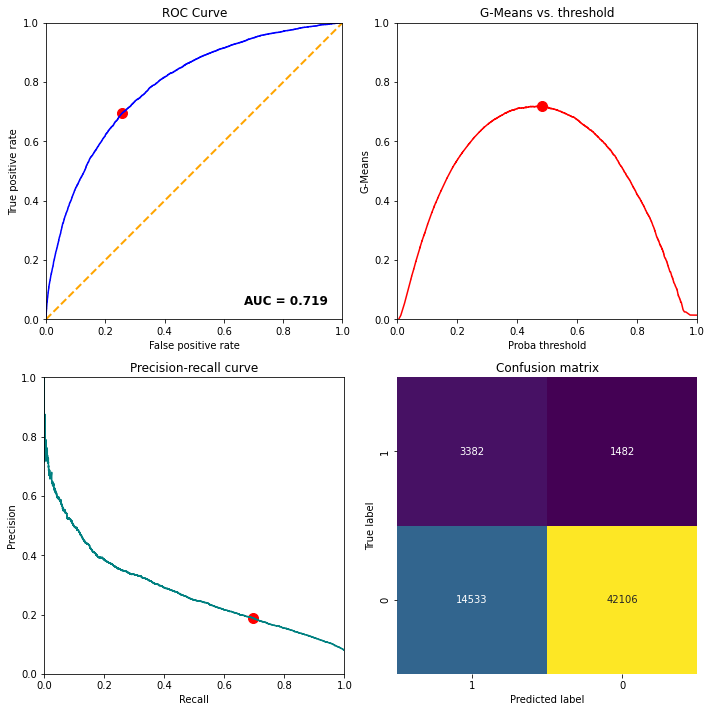

In [37]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_recall_curve
from sklearn import metrics


# predict probabilities
y_prob = model.predict_proba(X_test)

# keep probabilities for the positive outcome only
y_prob = y_prob[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
precision_, recall_, thresh_ = precision_recall_curve(y_test, y_prob)

# calculate the g-mean for each threshold
g_means = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(g_means)

y_prob = (y_prob >= thresholds[ix]).astype(bool)

tn, fp, fn, tp = confusion_matrix(y_test, y_prob).ravel()
print(f'TN = {tn}, FP = {fp}, FN = {fn}, TP = {tp}')
conf_mat = [[tp,fn],[fp,tn]]

auc = metrics.roc_auc_score(y_test, y_prob)
recall = metrics.recall_score(y_test, y_prob)
precision = metrics.precision_score(y_test, y_prob)
f1 = metrics.f1_score(y_test, y_prob)

######################################
print(f'Testset: \
threshold = {thresholds[ix]:.0%}, \
G-Mean = {g_means[ix]:.0%}, \
AUC = {auc:.0%}, \
recall = {recall:.0%}, \
precision = {precision:.0%}, \
f1 = {f1:.0%}')
######################################

# Evaluation plot
plt.figure(figsize=(10, 10))

# ROC curve
plt.subplot(221)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("ROC Curve")
plt.plot(fpr, tpr, label='LightGBM', color='blue')
plt.plot([0, 1], [0, 1], '--', lw=2, color='orange', label='no skill')
plt.scatter(fpr[ix], tpr[ix], marker='o', s=100, color='r', label='Best')
plt.text(0.95, 0.05, f'AUC = {auc:.3f}', ha='right',
         fontsize=12, weight='bold')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

# G-Means vs Threshold curve
plt.subplot(222)
plt.plot(thresholds, g_means, 'r')
plt.scatter(thresholds[ix], g_means[ix], marker='o', s=100, color='r', label='Best')
plt.xlim(0,1)
plt.xlabel('Proba threshold')
plt.ylim(0,1)
plt.ylabel('G-Means')
plt.title('G-Means vs. threshold')

# Precision recall curve 
plt.subplot(223)
plt.plot(recall_, precision_, 'teal')
plt.scatter(recall, precision, marker='o', s=100, color='r', label='Best')
plt.xlim(0,1)
plt.xlabel('Recall')
plt.ylim(0,1)
plt.ylabel('Precision')
plt.title('Precision-recall curve')

# Confusion matrix
plt.subplot(224)
sns.heatmap(conf_mat, annot=True, fmt='.0f', cbar=False, cmap='viridis')
plt.xticks([0.5,1.5], [1,0])
plt.yticks([0.5,1.5], [1,0])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')

plt.tight_layout(pad=1.1)
plt.show()

# Specific loss function model evaluation
## Hyperparameters tuning

In [28]:
# Research of best Hyperparamter with RandomSearch CV

from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

n = 10
weight = Counter(df['TARGET'])[0]/Counter(df['TARGET'])[1]

lgbm = LGBMClassifier(n_estimators=1000,
                      silent=-1,
                      verbose=-1,
                      metric='None',
                      n_jobs=-1,
                      application='binary',
                      learning_rate=0.02,
                      scale_pos_weight=weight,
                      )


lgbm_param = {'num_leaves': np.linspace(30, 45, 7, dtype='int'),
              'min_split_gain': stats.uniform(loc=0.1, scale=0.8),
              'min_child_weight': np.linspace(30, 45, 10),
              'subsample': stats.uniform(loc=0.1, scale=0.8),
              'colsample_bytree': stats.uniform(loc=0.1, scale=0.2),
              'max_depth': np.linspace(5, 15, 10, dtype='int'),
              'reg_alpha': np.linspace(0, 1, 10),
              'reg_lambda': np.linspace(0, 1, 10)}

grid = RandomizedSearchCV(lgbm,
                          lgbm_param,
                          n_iter=n,
                          cv=5,
                          scoring=score_function,
                          n_jobs=-1,
                          verbose=True,
                          random_state=13)

grid.fit(X_train, y_train)

print(round(grid.best_score_, 3))
print(grid.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.471
{'colsample_bytree': 0.21132641028688054, 'max_depth': 12, 'min_child_weight': 35.0, 'min_split_gain': 0.7717668083328567, 'num_leaves': 40, 'reg_alpha': 0.4444444444444444, 'reg_lambda': 0.6666666666666666, 'subsample': 0.46999559230818966}


In [31]:
# Fit the model with best params
NaN_remove=False
impute=False
sampling=False
feat_select=True
weight = Counter(df['TARGET'])[0]/Counter(df['TARGET'])[1]

X_train, y_train, X_test, y_test, feats = preprocessing(df,
                                                        NaN_remove=NaN_remove,
                                                        impute=impute,
                                                        sampling=sampling,
                                                        feat_select=feat_select)

model = LGBMClassifier(
            application='binary',
            n_estimators=1000,
            learning_rate=0.02,
            **grid.best_params_,
            scale_pos_weight=weight,
            silent=-1,
            verbose=-1,
            )
model.fit(X_train, y_train)

X shape before preprocessing:  (307511, 431)
Target distribution: Counter({0: 282686, 1: 24825})
Impute = False
X shape after preprocessing:  (307511, 541)
Features selection
X shape after features selection:  (307511, 143)
(246008, 144)
(61503, 144)
Preprocessing done in 81s


LGBMClassifier(application='binary', colsample_bytree=0.21132641028688054,
               learning_rate=0.02, max_depth=12, min_child_weight=35.0,
               min_split_gain=0.7717668083328567, n_estimators=1000,
               num_leaves=40, reg_alpha=0.4444444444444444,
               reg_lambda=0.6666666666666666,
               scale_pos_weight=11.387150050352467, silent=-1,
               subsample=0.46999559230818966, verbose=-1)

# Interpretability of the model

In [27]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance",
                y="feature",
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features')
    plt.tight_layout()

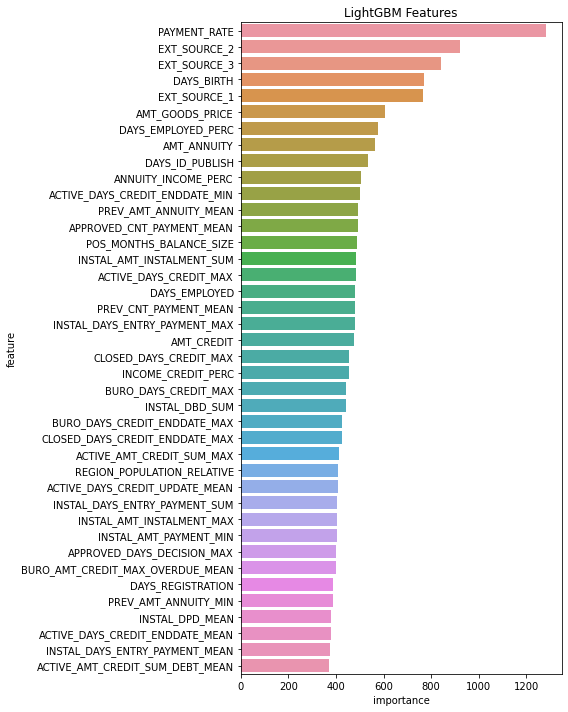

In [28]:
fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = feats
fold_importance_df["importance"] = model.feature_importances_
feature_importance_df = pd.DataFrame()
feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

display_importances(feature_importance_df)

In [29]:
# importing the libraries
from __future__ import print_function
from lime import lime_tabular
from lime.lime_tabular import LimeTabularExplainer

# saving the class names in a dictionary to increase interpretability
class_names = {0: 'No Difficulties', 1:'Payement Difficulties'}

In [30]:
# create the LIME explainer
# add the class names for interpretability
X_train = np.array(X_train)
X_test = np.array(X_test)
LIME_explainer = lime_tabular.LimeTabularExplainer(X_train, class_names=class_names, feature_names=feats)


In [31]:

idx = np.random.randint(1, len(X_test))

print('0 = No Difficulties, 1 = Payement Difficulties')
print("Prediction : ", model.predict(X_test[idx].reshape(1,-1))[0])
print("Actual :     ", np.array(y_test)[idx])

explanation = LIME_explainer.explain_instance(X_test[idx], model.predict_proba,
                                              num_features=20)

explanation.show_in_notebook()



0 = No Difficulties, 1 = Payement Difficulties
Prediction :  1
Actual :      0


In [32]:
# importing SHAP
import shap

# sampling data from the training and test set to reduce time-taken
X_train_sample = shap.sample(X_train, 8000)
X_test_sample = shap.sample(X_test, 2000)

# creating the KernelExplainer using the model and training sample
SHAP_explainer = shap.KernelExplainer(model.predict, X_train_sample)
# calculating the shap values of the test sample using the explainer 
shap_vals = SHAP_explainer.shap_values(X_test_sample)

# converting the test samples to a dataframe 
# this is necessary for non-tabular data in order for the visualisations 
# to include feature value
colour_test = pd.DataFrame(X_test_sample)

Using 8000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/2000 [00:00<?, ?it/s]

Error: Canceled future for execute_request message before replies were done

In [ ]:
shap.summary_plot(shap_vals, colour_test, feature_names=feats)

NameError: name 'shap_vals' is not defined

In [ ]:
shap.initjs()
shap.force_plot(SHAP_explainer.expected_value, shap_vals[1,:], 
                colour_test.iloc[1,:], feature_names=feats)